In [ ]:
import torch
import numpy as np
import torch.nn as nn
import cv2
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import save_image, make_grid
from PIL import Image, ImageFont, ImageDraw, ImageOps

In [ ]:
# create a transofrm to apply to each datapoint
transform = transforms.Compose([transforms.ToTensor()])

# download the MNIST datasets
path = '~/datasets'
train_dataset = MNIST(path, transform=transform, download=True)
test_dataset  = MNIST(path, transform=transform, download=True)

# create train and test dataloaders
batch_size = 100
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def digitize(number, plot=True, torch_return = False):
  height = 28
  width = 28
  channels = 1

  img_blank = np.ones((height,width), dtype=np.uint8)*255

  img_pil = Image.fromarray(img_blank.astype('uint8'))
  draw = ImageDraw.Draw(img_pil)
  myFont = ImageFont.truetype('FreeMonoBold.ttf', 36)
  _, _, w, h = draw.textbbox((0, 0), number, font=myFont)
  draw.text(((width-w)/2, -3+(height-h)/2), number, font=myFont, fill =0)

  if plot:
    img_digitized = np.array(img_pil).reshape(height,width)
    plt.imshow(img_digitized, cmap='gray', vmin=0, vmax=255)

  if torch_return:
    img_digitized = np.array(img_pil).reshape(channels, height, width) / 255.
    return torch.from_numpy(img_digitized).float()
  else:
    return np.array(img_pil).reshape(height,width)

torch.Size([1, 28, 28])


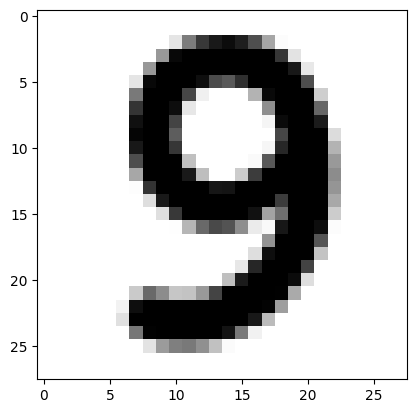

In [ ]:
dataiter = iter(train_loader)
image = next(dataiter)
#_ = digitize(str(image[1][2].item()))

img = digitize(str(image[1][2].item()), torch_return=True)
print(img.shape)

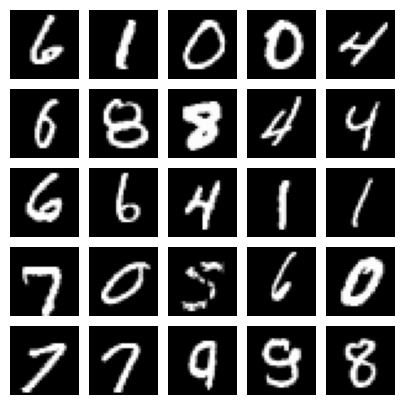

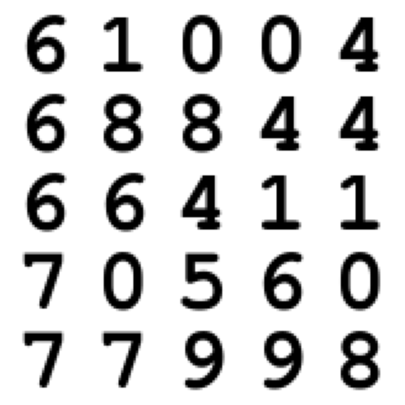

In [ ]:
# get 25 sample training images for visualization
dataiter = iter(train_loader)
image = next(dataiter)

num_samples = 25
sample_images = [image[0][i,0] for i in range(num_samples)]
number_image = [digitize(str(image[1][i].item()), plot=False) for i in range(num_samples)]

fig = plt.figure(figsize=(5, 5))
grid = ImageGrid(fig, 111, nrows_ncols=(5, 5), axes_pad=0.1)

for ax, im in zip(grid, sample_images):
    ax.imshow(im, cmap='gray')
    ax.axis('off')

fig2 = plt.figure(figsize=(5, 5))
grid2 = ImageGrid(fig2, 111, nrows_ncols=(5, 5), axes_pad=0.1)

for ax, im in zip(grid2, number_image):
    ax.imshow(im, cmap='gray')
    ax.axis('off')

plt.show()

In [ ]:
class VAE(nn.Module):

    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=200, device=device):
        super(VAE, self).__init__()

        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, latent_dim),
            nn.LeakyReLU(0.2)
            )

        # latent mean and variance
        self.mean_layer = nn.Linear(latent_dim, 2)
        self.logvar_layer = nn.Linear(latent_dim, 2)

        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, latent_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
            )

    def encode(self, x):
        x = self.encoder(x)
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device)
        z = mean + var*epsilon
        return z

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterization(mean, logvar)
        x_hat = self.decode(z)
        return x_hat, mean, logvar

    def forward(self, x):
        mean, log_var = self.encode(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var))
        x_hat = self.decode(z)
        return x_hat, mean, log_var

In [ ]:
model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

In [ ]:
def train(model, optimizer, epochs, device):
    model.train()
    for epoch in range(epochs):
        overall_loss = 0
        for batch_idx, (x, label) in enumerate(train_loader):
            x = x.view(batch_size, -1).to(device)

            x_ground_truth = [digitize(str(label[i].item()), plot = False, torch_return = True) for i in range(batch_size)]
            x_ground_truth = torch.stack(x_ground_truth)
            x_ground_truth = x_ground_truth.view(batch_size, -1).to(device)

            optimizer.zero_grad()

            x_hat, mean, log_var = model(x)
            loss = loss_function(x_ground_truth, x_hat, mean, log_var)

            overall_loss += loss.item()

            loss.backward()
            optimizer.step()

        print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss/(batch_idx*batch_size))
    return overall_loss

train(model, optimizer, epochs=23, device=device)

	Epoch 1 	Average Loss:  123.06385999778276
	Epoch 2 	Average Loss:  78.16278801257303
	Epoch 3 	Average Loss:  71.60441008451586
	Epoch 4 	Average Loss:  68.696431503678
	Epoch 5 	Average Loss:  66.54863410860548
	Epoch 6 	Average Loss:  65.19960596762834
	Epoch 7 	Average Loss:  63.862881756051756
	Epoch 8 	Average Loss:  63.68535182335142
	Epoch 9 	Average Loss:  62.81531145659432
	Epoch 10 	Average Loss:  62.044754506208264
	Epoch 11 	Average Loss:  61.71527592374009
	Epoch 12 	Average Loss:  61.309296989122494
	Epoch 13 	Average Loss:  60.918437426635535
	Epoch 14 	Average Loss:  60.465601450007824
	Epoch 15 	Average Loss:  60.079746811091404
	Epoch 16 	Average Loss:  60.22804671196786
	Epoch 17 	Average Loss:  59.87926894759495
	Epoch 18 	Average Loss:  59.38911028471932
	Epoch 19 	Average Loss:  59.218043606205654
	Epoch 20 	Average Loss:  59.4205241238653
	Epoch 21 	Average Loss:  58.63080729438387
	Epoch 22 	Average Loss:  58.773337129264924
	Epoch 23 	Average Loss:  58.614160

3354961.353515625

In [ ]:
torch.save(model, "Model1.pt")

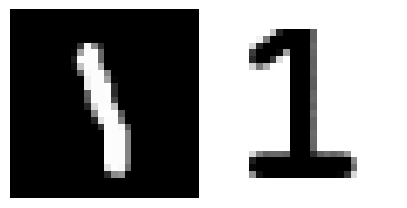

In [ ]:
dataiter = iter(test_loader)
image = next(dataiter)
image_main = image[0][0]
img = image_main.view(1, -1)
dig_img,_,_ = model(img.to(device))

dig_img = dig_img.detach().cpu().reshape(28,28)

fig = plt.figure(figsize=(5, 5))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 2), axes_pad=0.1)

grid[0].imshow(image_main[0], cmap='gray')
grid[0].axis('off')

grid[1].imshow(dig_img, cmap='gray')
grid[1].axis('off')

plt.show()